Device: cuda:0 IMGSIZE:( 3 224 224 ) BatchSize: 8 Epochs: 200 Valsplit: 0.25 Class: ['Damage', 'NoDamage'] Final Layer Nodes: 2048
TrainData Size: 1647 TrainData Batches 206 ValData Size: 549 ValData Batches: 69
Epoch 1 TrainLoss: 0.6598 TrainAcc: 0.6108
Epoch 1 ValLoss: 0.6762 ValAcc: 0.5938
 
Epoch 2 TrainLoss: 0.5470 TrainAcc: 0.7171
Epoch 2 ValLoss: 0.4936 ValAcc: 0.7432
 
Epoch 3 TrainLoss: 0.4438 TrainAcc: 0.7875
Epoch 3 ValLoss: 0.4145 ValAcc: 0.7905
 
Epoch 4 TrainLoss: 0.3935 TrainAcc: 0.8081
Epoch 4 ValLoss: 0.3594 ValAcc: 0.8179
 
Epoch 5 TrainLoss: 0.2939 TrainAcc: 0.8634
Epoch 5 ValLoss: 0.3344 ValAcc: 0.8270
 
Epoch 6 TrainLoss: 0.2454 TrainAcc: 0.8883
Epoch 6 ValLoss: 0.3154 ValAcc: 0.8306
 
Epoch 7 TrainLoss: 0.1918 TrainAcc: 0.9259
Epoch 7 ValLoss: 0.2039 ValAcc: 0.9089
 
Epoch 8 TrainLoss: 0.1334 TrainAcc: 0.9466
Epoch 8 ValLoss: 0.1580 ValAcc: 0.9235
 
Epoch 9 TrainLoss: 0.1234 TrainAcc: 0.9545
Epoch 9 ValLoss: 0.1180 ValAcc: 0.9490
 
Epoch 10 TrainLoss: 0.0900 Train

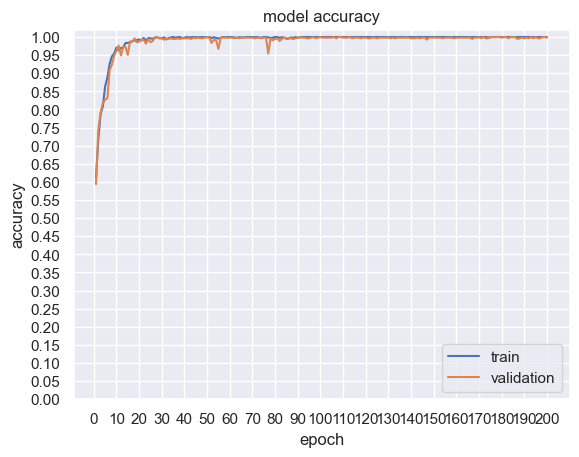

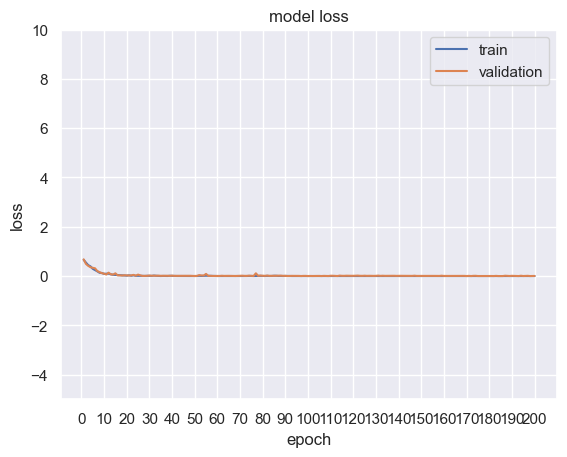

Training Finished!!!
Model in Epoch 10
Loss:  0.3078826069831848
Accuracy:  0.90625

Model in Epoch 20
Loss:  0.7134976387023926
Accuracy:  0.875

Model in Epoch 30
Loss:  0.5752948522567749
Accuracy:  0.828125

Model in Epoch 40
Loss:  0.9002984166145325
Accuracy:  0.765625

Model in Epoch 50
Loss:  0.9684140682220459
Accuracy:  0.8125

Model in Epoch 60
Loss:  0.5744506120681763
Accuracy:  0.8125

Model in Epoch 70
Loss:  0.5823916792869568
Accuracy:  0.859375

Model in Epoch 80
Loss:  0.7885542511940002
Accuracy:  0.8125

Model in Epoch 90
Loss:  0.42331069707870483
Accuracy:  0.828125

Model in Epoch 100
Loss:  0.42804449796676636
Accuracy:  0.84375

Model in Epoch 110
Loss:  0.41415339708328247
Accuracy:  0.84375

Model in Epoch 120
Loss:  0.6132067441940308
Accuracy:  0.828125

Model in Epoch 130
Loss:  0.664362370967865
Accuracy:  0.828125

Model in Epoch 140
Loss:  0.5972742438316345
Accuracy:  0.84375

Model in Epoch 150
Loss:  0.5044017434120178
Accuracy:  0.859375

Model in 

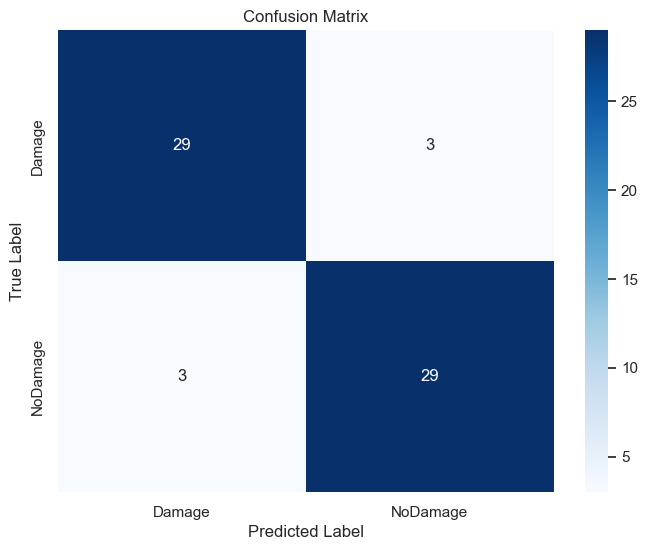

-Test Loss: 0.3079 Test Accuracy: 0.9062
Calculation Finished in  20250422_2033


In [10]:
import glob
import os
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms.functional as TF
from torchvision.transforms import v2
import torchvision.models as models
import torch.nn as nn
import cv2
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
from typing import List, Tuple
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

time = datetime.datetime.now()
filedate=time.strftime('%Y%m%d_%H%M')

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# 定数の設定
Channels = 3
batch_size = 8
IMG_SIZE = 224
valsplit = 0.25
epochlist=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
epochs = epochlist[-1]


# クラスの設定
Classes = ["Damage", "NoDamage"]
ClassNum = len(Classes)

# パス設定
trainpath = r"..\20241023Data\Train_BrightContrast"
testpath = r"..\20241023Data\Test"
savepath = r"..\20241023Data\Weights"
historypath = r"..\20241023Data\History"
resultspath = r"..\20241023Data\Results"

'''
PytorchではDataloaderという,膨大なデータセットからでもメモリを圧迫せずに取り出せてforループにも対応するための枠組みがある
データセットをDataloaderが引っ張ってこれるような形式にするためにMyDataset(torch.utils.data.Dataset)というクラスを作れば，
あとはそのメソッドをtorch.utils.data.Datasetが勝手に使用してデータを加工してくれる
__init__, __getitem__, __len__をクラス内で必ず定義しなければならない
Dataloader内のデータはバッチごとにまとめられる
'''
class MyDataset(Dataset):
    def __init__(self, root: str, transforms, Classes) -> None:
        super().__init__()
        self.transforms = transforms
        self.Classes = Classes
        #globは複数のファイルのパスをまとめて取得する
        #訓練と訓練白黒の二個下のディレクトリから画像を取得
        self.data = list(sorted(Path(root).glob("*\*")))

    #__getitem__は，MyDataset型のインスタンスでdataset[1]みたいに要素番号呼び出しをされたときに自動で行う処理(Pythonデフォ付属)
    # ここで取り出すデータを指定している
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        data = self.data[index]
        #OpenCVで読み込むときは必ずRGBに変換
        img1 = cv2.cvtColor(cv2.imread(str(data)), cv2.COLOR_BGR2RGB)
        img1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE))
        img1 = TF.to_tensor(img1)

        # データの変形 (transforms)
        transformed_img = self.transforms(img1)

        #ラベル貼り：dataというパスを/で区切ってリストにし，クラス名のところをラベルに格納
        #クラス名は文字列なので，self.Classesの要素と比較して一致するところの番号をラベルとする
        label = str(data).split("\\")[-2]
        label = torch.tensor(self.Classes.index(label))

        return transformed_img, label, str(data)

    # この method がないと DataLoader を呼び出す際にエラーを吐かれる
    def __len__(self) -> int:
        return len(self.data)


#入力データに施す処理
transforms = v2.Compose([
        #v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0,0,0], std=[0.2, 0.2, 0.2]),
])


trainvalset = MyDataset(root=trainpath, transforms=transforms, Classes=Classes)
trainset, valset = random_split(trainvalset, [1-valsplit, valsplit])

trainloader = DataLoader(dataset=trainset,batch_size=batch_size,shuffle=True)
valloader = DataLoader(dataset=valset,batch_size=batch_size,shuffle=True)

# モデルの初期化関数
def initialize_model():
    model = models.resnet50(weights='DEFAULT')
    #チャンネル数いじれるようにしておく
    model.conv1 = torch.nn.Conv2d(Channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, ClassNum)
    return model.to(device)


model = initialize_model()

#lossfunction&optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print("Device:", device, "IMGSIZE:(", Channels, IMG_SIZE, IMG_SIZE, ")",  "BatchSize:", batch_size, "Epochs:", epochs, "Valsplit:", valsplit, "Class:", Classes, "Final Layer Nodes:", num_ftrs)

'''
trainiterator
enumerateはtrainloader内のすべてのdataに対してループし，繰り返し回数をbatchに渡すという意味
Dataloader内ではバッチごとにデータがまとめられるので1回の取り出しで1バッチ分のデータを丸々取り出せる
'''
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train(trainloader, valloader, model, loss_fn, optimizer, epochs):
    size = len(trainloader.dataset)
    num_batches = len(trainloader)
    size_val = len(valloader.dataset)
    num_batches_val = len(valloader)
    print("TrainData Size:", size, "TrainData Batches", num_batches, "ValData Size:", size_val, "ValData Batches:", num_batches_val)
    for epoch in range(epochs):
        running_loss, running_correct = 0, 0
        val_loss, val_correct = 0, 0
        for batch, (X, y, _) in enumerate(trainloader):
            X=X.to(device)
            y=y.to(device)
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            #損失と正解数の合計を計算しておき，後でそのエポック内での平均をとる
            running_loss += loss.item()
            running_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        epoch_loss = running_loss / num_batches
        epoch_acc = running_correct / size

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch + 1} TrainLoss: {epoch_loss:.4f} TrainAcc: {epoch_acc:.4f}')

        # Set the model to evaluation mode - important for batch normalization and dropout layers
        model.eval()
        # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
        with torch.no_grad():
            for X, y, _ in valloader:
                X=X.to(device)
                y=y.to(device)
                pred = model(X)
                val_loss += loss_fn(pred, y).item()
                val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            val_loss /= num_batches_val
            val_correct /= size_val
        # Set the model to train mode
        model.train()

        val_losses.append(val_loss)
        val_accuracies.append(val_correct)

        print(f'Epoch {epoch + 1} ValLoss: {val_loss:.4f} ValAcc: {val_correct:.4f}')

        #10epoch毎にパラメータを別々のフォルダに保存
        e1=epoch+1
        if (e1 % 10 == 0):
            savepath2 = Path(savepath+"\\"+str(e1)+"\model_weights"+filedate+".pth")
            print('Saving Model...')
            torch.save(model.state_dict(), savepath2)
            print('Model saved in', savepath2)

        print(' ')

train(trainloader, valloader, model, loss_fn, optimizer, epochs)

#グラフ可視化
#pltの(x,y)のxにあたるepochのリスト　1から開始
ep=np.arange(1, epochs+1)

#グラフにプロットする正解率と損失のリストをCSVに書き出し to_csvは新規フォルダを作ってくれないのでosで作る
historypath2 = str(Path(historypath+"\\"+filedate))
os.mkdir(historypath2)
pd.DataFrame(data=np.array([ep, train_accuracies]).T, columns=["Epoch", "Accuracy"]).to_csv(Path(historypath2+"\\"+"Train_Acc.csv"))
pd.DataFrame(data=np.array([ep, train_losses]).T, columns=["Epoch", "Loss"]).to_csv(Path(historypath2+"\\"+"Train_Loss.csv"))
pd.DataFrame(data=np.array([ep, val_accuracies]).T, columns=["Epoch", "Accuracy"]).to_csv(Path(historypath2+"\\"+"Val_Acc.csv"))
pd.DataFrame(data=np.array([ep, val_losses]).T, columns=["Epoch", "Loss"]).to_csv(Path(historypath2+"\\"+"Val_Loss.csv"))
print("CSVs saved in", historypath2)

def plot_acc(train_accuracies, val_accuracies):
    plt.plot(ep, train_accuracies)
    plt.plot(ep, val_accuracies)
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.xticks(np.arange(0, epochs+1, 10))
    plt.yticks(np.arange(0.0, 1.05, 0.05))
    plt.legend(["train", "validation"], loc="lower right")
    plt.show()

def plot_loss(train_losses, val_losses):
    plt.plot(ep, train_losses)
    plt.plot(ep, val_losses)
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.xticks(np.arange(0, epochs+1, 10))
    plt.ylim(bottom=-5, top=10)
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()

plot_acc(train_accuracies, val_accuracies)
plot_loss(train_losses, val_losses)

print('Training Finished!!!')


#各エポックのモデルを評価する
def BestEpochModel_Evaluate(testloader, loss_fn, fold=None):
    epochmodel_accuracies=[]
    
    #各エポックで止めたモデルの中から最良のモデルを選択
    for e in epochlist:
        #モデル構築
        epochmodelpath = Path(savepath+"\\"+str(e)+"\model_weights"+filedate+(f"_fold{fold}" if fold else "")+".pth")
        epochmodel = initialize_model()
        epochmodel.load_state_dict(torch.load(epochmodelpath))
        #GPUにニューラルネットワークを渡す
        epochmodel=epochmodel.to(device)
    
        print("Model in Epoch", e)
        # テストデータでの評価
        epochmodel.eval()
        y_true = []
        y_pred = []
        file_paths = []
        size_test = len(testloader.dataset)
        test_loss, test_correct = 0, 0
        
        with torch.no_grad():
            for X, y, paths in testloader:
                X = X.to(device)
                y = y.to(device)
                outputs = epochmodel(X)
                #torch.maxの一番目の戻り値は確率．二番目の戻り値は，クラス番号　なのでクラス番号だけ取り出す
                _, predicted = torch.max(outputs, 1)
                
                test_loss += loss_fn(outputs, y).item()
                test_correct += (outputs.argmax(1) == y).type(torch.float).sum().item()
    
            test_correct /= size_test

        epochmodel_accuracies.append(test_correct)
        
        print("Loss: ", test_loss)
        print("Accuracy: ", test_correct)
        print()

    #エポックと精度の対応表からベストモデル算定
    ep_acc_df= pd.DataFrame({
        "epoch": epochlist, 
        "accuracy": epochmodel_accuracies
    })
    
    bestepoch = ep_acc_df.loc[ep_acc_df["accuracy"].idxmax(), "epoch"]

    #ベストモデル構築
    bestmodelpath = Path(savepath+"\\"+str(bestepoch)+"\model_weights"+filedate+(f"_fold{fold}" if fold else "")+".pth")
    bestmodel = initialize_model()
    bestmodel.load_state_dict(torch.load(bestmodelpath))
    #GPUにニューラルネットワークを渡す
    bestmodel=bestmodel.to(device)
    
    print("best epoch: ", bestepoch)

    return bestmodel

# 評価関数（混同行列と分類結果をCSVに出力）
def evaluate_model(model, testloader, loss_fn, fold=None):
    model.eval()
    y_true = []
    y_pred = []
    file_paths = []
    size_test = len(testloader.dataset)
    test_loss, test_correct = 0, 0
    
    with torch.no_grad():
        for X, y, paths in testloader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            #torch.maxの一番目の戻り値は確率．二番目の戻り値は，クラス番号　なのでクラス番号だけ取り出す
            _, predicted = torch.max(outputs, 1)
            
            test_loss += loss_fn(outputs, y).item()
            test_correct += (outputs.argmax(1) == y).type(torch.float).sum().item()

            #appendでリストにリストを追加するとリスト内にリストがある二重状態になってしまう　extend関数で2重リストにすることなく格納
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            file_paths.extend(paths)

        test_correct /= size_test

    print(f'TestLoss: {test_loss:.4f} TestAcc: {test_correct:.4f}')
    
    # 混同行列の作成
    cm = confusion_matrix(y_true, y_pred)
    
    # 結果を出力
    print("\nConfusion Matrix:")
    print(cm)
    
    # 分類レポートの出力
    report = classification_report(y_true, y_pred, target_names=Classes)
    print("\nClassification Report:")
    print(report)
    
    # 分類結果をCSVに出力
    results_df = pd.DataFrame({
        'FilePath': file_paths,
        'TrueLabel': [Classes[i] for i in y_true],
        'PredictedLabel': [Classes[i] for i in y_pred],
        'Correct': [y_true[i] == y_pred[i] for i in range(len(y_true))]
    })
    
    # 結果ディレクトリがなければ作成
    os.makedirs(resultspath, exist_ok=True)
    
    # foldが指定されている場合は、フォルドごとの結果ファイルを作成
    if fold is not None:
        csv_path = os.path.join(resultspath, f"classification_results_fold{fold}_{filedate}.csv")
    else:
        csv_path = os.path.join(resultspath, f"classification_results_{filedate}.csv")
    
    results_df.to_csv(csv_path, index=False)
    print(f"Classification results saved to: {csv_path}")
    
    return cm, results_df, test_loss, test_correct

# 混同行列の可視化
def plot_confusion_matrix(cm, fold=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Classes, yticklabels=Classes)
    plt.title('Confusion Matrix' + (f" - Fold {fold}" if fold else ""))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 保存
    history_fold_path = historypath + "\\" + filedate + (f"_fold{fold}" if fold else "")
    os.makedirs(history_fold_path, exist_ok=True)
    plt.savefig(os.path.join(history_fold_path, "confusion_matrix.png"))
    plt.show()

testset= MyDataset(root=testpath, transforms=transforms, Classes=Classes)

testloader = DataLoader(dataset=testset,batch_size=len(testset),shuffle=True)

bestmodel = BestEpochModel_Evaluate(testloader, loss_fn)
        
cm, results_df, test_loss, test_correct = evaluate_model(bestmodel, testloader, loss_fn)

# 混同行列の可視化
plot_confusion_matrix(cm)

# 最終精度をprint
print(f"-Test Loss: {test_loss:.4f} Test Accuracy: {test_correct:.4f}")

# 計算終了時間の取得とフォーマット
finishtime = datetime.datetime.now()
finishdate = finishtime.strftime('%Y%m%d_%H%M')
datepath=str(Path(resultspath + "\calc_time_" + filedate + ".txt"))

# ファイルを新規作成し、日付を書き込む
with open(datepath, 'w', encoding='utf-8') as f:
    f.write(filedate)
    f.write(finishdate)

print("Calculation Finished in ", finishdate)